In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import warnings
# 忽略 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

D:\Soft\code_soft\anaconda\envs\rgis9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 定义函数


In [3]:
def calculate_error(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return U95
    return {
        "R": round(R, 3),
        "MBE": round(MBE, 3),
        # "%MBE": MBE_percent,
        "RMSE": round(RMSE, 3),
        # "%RMSE": RMSE_percent,
        "U95": round(U95, 3)
    }

### 12分组计算指标，转Origin绘制

In [4]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2", "ISCCP-ITP":"ISCCP"})
station_data = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "climate_type_name"]]
# 添加气候类型字段
database = pd.merge(database, station_data, on="originalID", how="left" ).rename(columns={'climate_type_name':'climate'})
# drop没用的字段
database = database.drop(columns=["originalID", "stationIndex", "date", "lat", "lon"])

In [11]:
# 获取所有不同的气候类型
climate_types = database['climate'].unique()
climate_types.sort()  # 确保类型有序

# 数据产品列名
product_columns = ['ISCCP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

# 定义要计算的指标
metrics = ["R", "RMSE", "MBE", "U95"]

# 创建一个 ExcelWriter 对象
with pd.ExcelWriter('datas/12气候类型-评价指标.xlsx') as writer:
    # 用于存储所有气候类型下所有产品的误差
    all_climate_errors = {}

    for metric in metrics:
        print(f"---------------Calculating {metric} for each climate type---------------")
        # 创建一个空的 DataFrame 来存储当前指标的结果
        result_df = pd.DataFrame(index=climate_types, columns=product_columns)

        for i, climate_type in enumerate(climate_types):
            # 筛选出当前气候类型的数据
            climate_data = database[database['climate'] == climate_type]
            # 初始化当前lc_type的所有数据
            climate_type_data = pd.DataFrame(columns=["Observation", "Productions"])
            # 计算每种数据产品与观测值的误差
            errors = []

            for column in product_columns:
                climate_data_filter = climate_data[~climate_data[column].isna()][["Observation", column]].reset_index(drop=True)
                # 计算当前climate下，当前产品的误差
                error_dict = calculate_error(climate_data_filter['Observation'], climate_data_filter[column])
                # 正确从字典中提取所需指标的值
                error = error_dict[metric]
                errors.append(error)
                # 将误差值存入 DataFrame
                result_df.loc[climate_type, column] = error
                # 计算当前climate下，所有产品的误差
                climate_data_filter_temp = climate_data_filter.rename(columns={column: 'Productions'})
                # 将数据添加到climate_type_data中
                climate_type_data = pd.concat([climate_type_data, climate_data_filter_temp])

            if metric == "R":
                climate_type_error_dict = calculate_error(climate_type_data['Observation'], climate_type_data["Productions"])
                all_climate_errors[climate_type] = climate_type_error_dict
                print(f"{climate_type}: {climate_type_error_dict}")

        # 将当前指标的结果保存到 Excel 文件的一个 sheet 中
        result_df.to_excel(writer, sheet_name=metric)

    # 将所有气候类型下所有产品的误差保存到一个单独的 sheet 中
    all_climate_errors_df = pd.DataFrame.from_dict(all_climate_errors, orient='index')
    all_climate_errors_df.to_excel(writer, sheet_name='All_Climate_Errors')

---------------Calculating R for each climate type---------------
Af: {'R': 0.486, 'MBE': -4.935, 'RMSE': 45.123, 'U95': 21.423}
Am: {'R': 0.629, 'MBE': 2.959, 'RMSE': 37.486, 'U95': 18.27}
Aw: {'R': 0.683, 'MBE': 1.641, 'RMSE': 33.119, 'U95': 14.676}
BSh: {'R': 0.957, 'MBE': 14.947, 'RMSE': 29.196, 'U95': 15.676}
BSk: {'R': 0.898, 'MBE': -4.245, 'RMSE': 27.106, 'U95': 11.057}
BWh: {'R': 0.948, 'MBE': 10.923, 'RMSE': 30.25, 'U95': 15.968}
BWk: {'R': 0.926, 'MBE': -0.318, 'RMSE': 27.887, 'U95': 11.899}
Cfa: {'R': 0.893, 'MBE': 5.212, 'RMSE': 35.783, 'U95': 18.202}
Cfb: {'R': 0.95, 'MBE': 6.883, 'RMSE': 32.837, 'U95': 20.081}
Csa: {'R': 0.96, 'MBE': 0.007, 'RMSE': 28.5, 'U95': 13.377}
Csb: {'R': 0.958, 'MBE': -1.951, 'RMSE': 30.514, 'U95': 14.271}
Cwa: {'R': 0.838, 'MBE': 11.146, 'RMSE': 37.183, 'U95': 20.085}
Cwb: {'R': 0.764, 'MBE': 4.496, 'RMSE': 35.954, 'U95': 17.2}
Dfa: {'R': 0.944, 'MBE': 4.533, 'RMSE': 31.532, 'U95': 16.036}
Dfb: {'R': 0.948, 'MBE': 5.335, 'RMSE': 33.092, 'U95': 1

### 12绘制环形折线图

In [36]:
# 读取数据
data = pd.read_excel('datas/12气候类型-评价指标.xlsx', sheet_name='All_Climate_Errors')
# 为每个指标指定 climate_type 的绘制顺序
order_R    = ["Af", "Am", "Aw", "Cwb", "BSh", "Dsc", "Dsd", "ET", "BWh","Cfb", "Dfb", "Dfa", "Dwa", "Csa", "Csb", "Dfc", "BWk", "Dwb", "Dwc", "EF", "BSk","Cfa", "Cwa", "OC"]
order_RMSE = ["Af", "OC", "Am", "Cwb", "Aw", "Cfa", "Cwa", "BSh", "Dfc","Csa", "BSk", "BWh", "Dwb", "Csb", "BWk", "Dwa", "Dsc", "Dsd", "Dwc", "Cfb", "Dfb","Dfa", "EF", "ET"]
order_MBE  = ["Af", "OC", "Am", "Aw", "BWk", "Csa", "Cfa", "Dwb", "BSk","Cfb", "Dfa", "Dfb", "Dfc", "Csb", "ET", "Dsc", "Dsd", "EF", "Cwb", "BSh", "BWh","Dwc", "Cwa", "Dwa"]
order_U95  = ["Af", "Cwa", "Am", "Cwb", "Aw", "BSk", "BWk", "Csa", "Csb","BSh", "Dfa", "BWh", "Dwb", "Dwa", "Dwc", "Cfa", "Cfb", "Dfb", "Dfc", "Dsc", "EF","ET", "Dsd", "OC"]


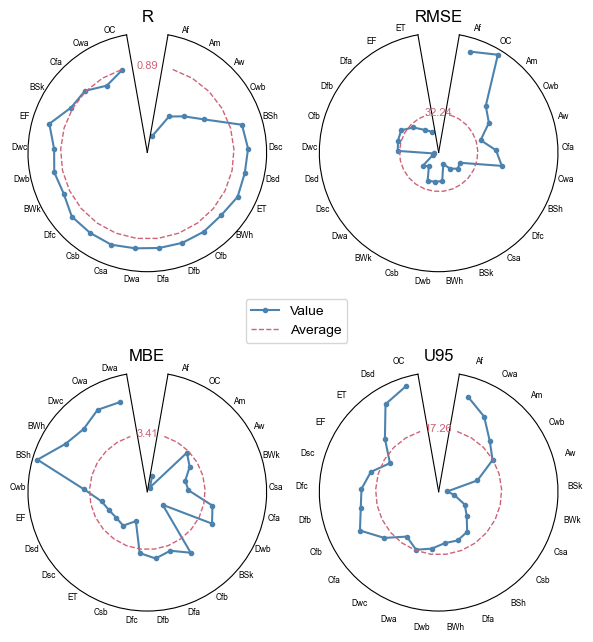

In [72]:
# 定义一个函数来绘制极坐标折线图
def plot_polar_chart(ax, data, column, order):
    # 按指定顺序对 DataFrame 排序
    df_sorted = data.set_index('climate_type').loc[order].reset_index()
    # 从 DataFrame 中提取对应列的值
    radii = df_sorted[column].values

    # 生成角度数据，从10°开始，终止于350°，共24个数据点
    angles = np.linspace(np.radians(17.08), np.radians(342.92), 24)

    # 计算半径的平均值
    mean_radius = np.mean(radii)

    # 设置角度零点位置为正上方
    ax.set_theta_zero_location('N')
    # 设置角度方向为逆时针
    ax.set_theta_direction(-1)

    # 设置角度刻度范围
    ax.set_thetamin(10)
    ax.set_thetamax(350)

    # 设置半径刻度范围
    if column == "R":
        min_r = np.min(radii) - 0.1
        max_r = np.max(radii) + 0.1
    else:
        min_r = np.min(radii) - 1
        max_r = np.max(radii) + 1
    # 极坐标中Y轴表示半径， X轴表示角度
    ax.set_ylim(min_r, max_r)
    # ax.set_xticklabels([]) # 隐藏X轴刻度标签
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)

    # 绘制折线图
    ax.plot(angles, radii, '.-', linewidth = 1.5, color="#4c83ae", label='Value')

    # 绘制平均值弧线
    ax.plot(angles, np.full_like(angles, mean_radius), '--', linewidth = 1, color='#ce6377', label='Average')
    # 添加平均值弧线的值标签
    label_angle = angles[len(angles) // 2]  # 选择中间的角度位置添加标签
    # ax.text(label_angle, mean_radius, f'{mean_radius:.2f}', ha='center', va='center', color='red', fontsize=8)
    ax.text(0, mean_radius, f'{mean_radius:.2f}', ha='center', va='center', color='#ce6377', fontsize=8)

    # 添加 climate_type 作为标签
    for angle, radius, label in zip(angles, radii, df_sorted['climate_type']):
        ax.text(angle, (max_r+0.05) if column == "R" else max_r+2  , label, ha='center', va='center', fontsize = 6)

    # 设置标题
    ax.set_title(column, va='bottom')

    # 添加图例
    # ax.legend(fontsize='small')


# 创建 2x2 的子图布局
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True), figsize=(6, 7))
axs = axs.flatten()

# 分别绘制四个指标的极坐标折线图
plot_polar_chart(axs[0], data, 'R', order_R)
plot_polar_chart(axs[1], data, 'RMSE', order_RMSE)
plot_polar_chart(axs[2], data, 'MBE', order_MBE)
plot_polar_chart(axs[3], data, 'U95', order_U95)

# 获取第一个子图的图例句柄和标签
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
plt.tight_layout()
# 保存为矢量
fig.savefig('figs/12-环形折线图.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()